# Выбор локации для скважины

**Описание проекта**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


**Шаги выполнения проекта:**

1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков
5. Общий вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
TEST_SIZE = 0.25
RANDOM_STATE = np.random.RandomState(42)

## Загрузка и подготовка данных

### Загрузка и просмотр данных

In [3]:
try:
    data0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except:
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропуски в данных отсутствуют

### Предобработка

In [10]:
data0['id'].value_counts()

AGS9W    2
QcMuo    2
Tdehs    2
TtcGQ    2
bxg6G    2
        ..
sTYgm    1
WzuiG    1
oqxHu    1
P7JIF    1
7llh7    1
Name: id, Length: 99990, dtype: int64

In [11]:
data1['id'].value_counts()

LHZR0    2
wt4Uk    2
5ltQ6    2
bfPNe    2
U4KLL    1
        ..
EIgxE    1
QGa0Z    1
bCV22    1
YVsbu    1
ezjhe    1
Name: id, Length: 99996, dtype: int64

In [12]:
data2['id'].value_counts()

xCHr8    2
VF7Jo    2
KUPhW    2
Vcm5J    2
g66TQ    1
        ..
rl19a    1
a4bQk    1
MMl81    1
26EQc    1
8QoxP    1
Name: id, Length: 99996, dtype: int64

Присутствуют дубликаты в индексах, поэтому удалим их

In [13]:
data0 = data0[~data0['id'].duplicated()]
data1 = data1[~data1['id'].duplicated()]
data2 = data2[~data2['id'].duplicated()]

Для удобства переведем `id` в индекс

In [14]:
data0 = data0.set_index('id')
data1 = data1.set_index('id')
data2 = data2.set_index('id')

### Исследовательский анализ данных 

In [15]:
def histplot(data):
    plt.figure(figsize=(16, 9))
    plt.suptitle('Распределение числовых значений', fontsize=15)
    columns_names = data.select_dtypes(include='number').columns

    for i, col in zip(range(1, 5), columns_names):
        plt.subplot(2,2,i)
        sns.histplot(data=data, x=col, kde=True)

In [16]:
def boxplot(data): 
    plt.figure(figsize=(10, 8))
    plt.suptitle('Распределение числовых значений', fontsize=15)
    columns_names = data.select_dtypes(include='number').columns

    for i, col in zip(range(1, 5), columns_names):
        plt.subplot(2,2,i)
        plt.boxplot(data=data, x=col, patch_artist=True)
        plt.ylabel(col)

#### data0 

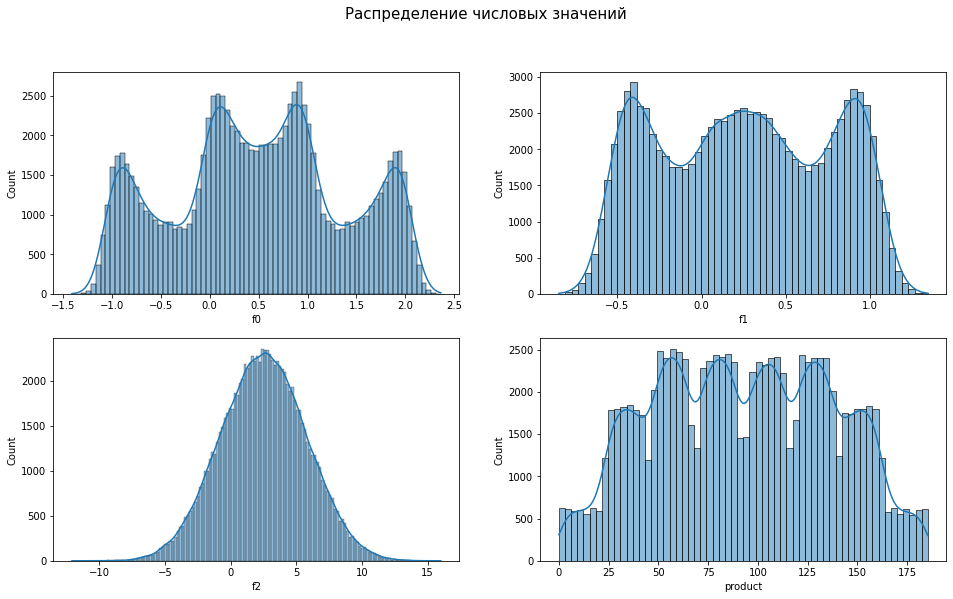

In [17]:
histplot(data0)

- f0, f1 и product имеют несколько пиков и распределены ненормально
- f2 распределена по Гауссу

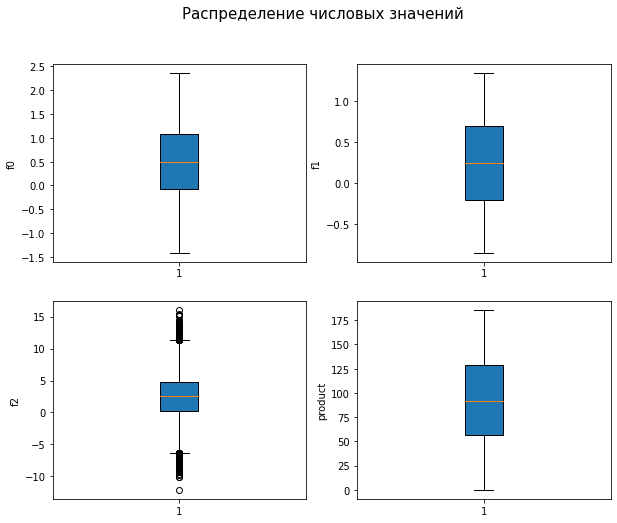

In [18]:
boxplot(data0)

Очень смльные шумы у показателя f2

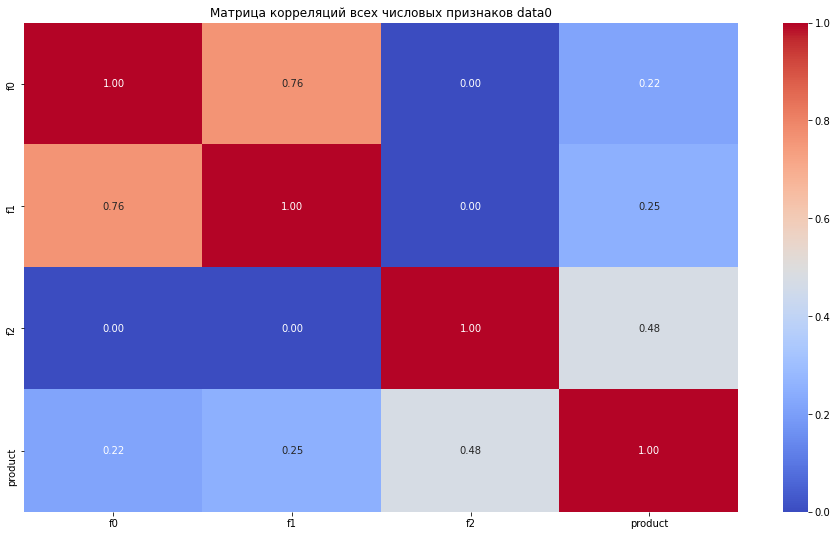

In [19]:
corr_matrix = data0.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product', 'f1_1'])
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Матрица корреляций всех числовых признаков data0')
plt.show();

Из матрицы корреляций было получено, что между f1 и f0 высокая зависимость 

Посмотрим диаграммы рассеяния, чтоб рассмотреть функциональные зависимости

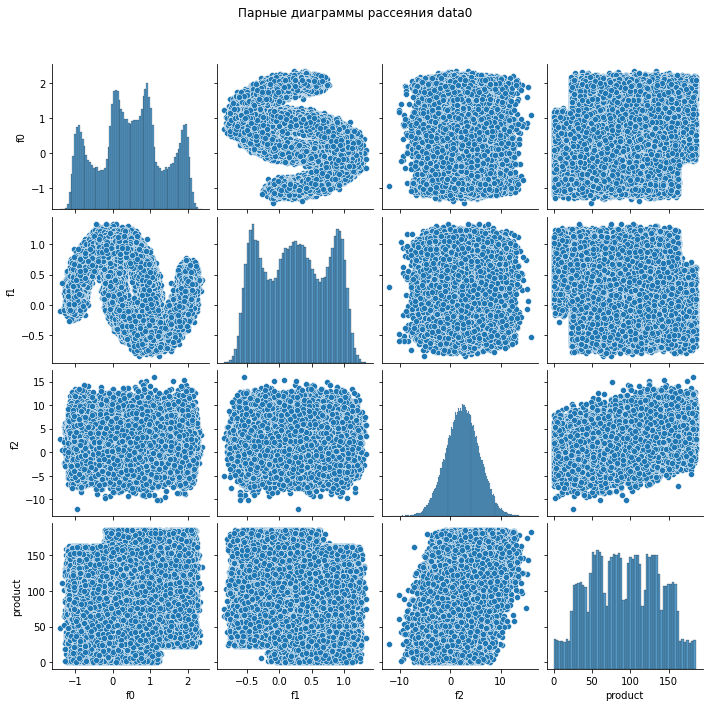

In [20]:
ax = sns.pairplot(data0)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Парные диаграммы рассеяния data0');

Есть выраженная зависимость между f1 и f0, похожая на периодическую функцию 

#### data1

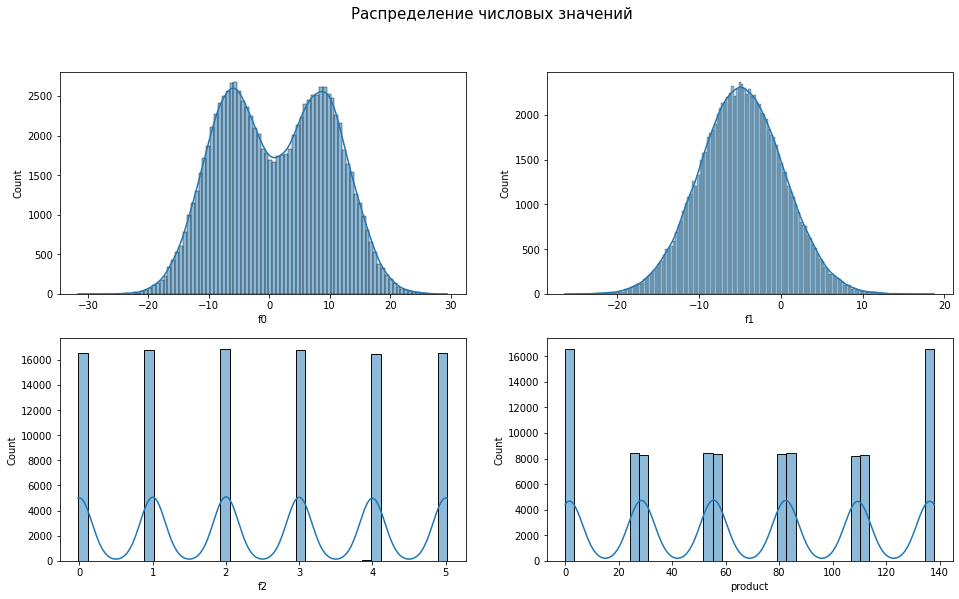

In [21]:
histplot(data1)

- f1 распределена нормально
- f0 имеет два пика
- Распределение f2 и product похоже на дискретное, но это не так в данном случае значения варьируются около определенных чисел, поэтому такое распределение

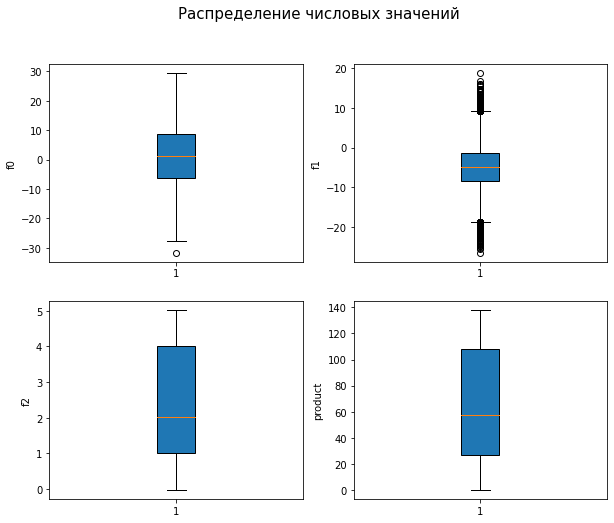

In [22]:
boxplot(data1)

Высокие шумы у f1

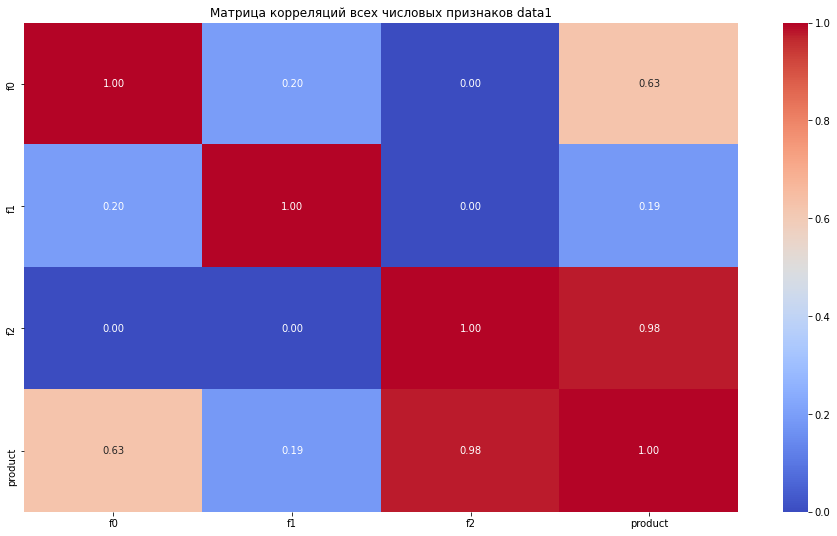

In [23]:
corr_matrix = data1.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Матрица корреляций всех числовых признаков data1')
plt.show();

Мультиколлениарность между f2 и product, скорее всего придется удалить признак f2, решим это опытным путем обучив модель без этого признакак и с ним

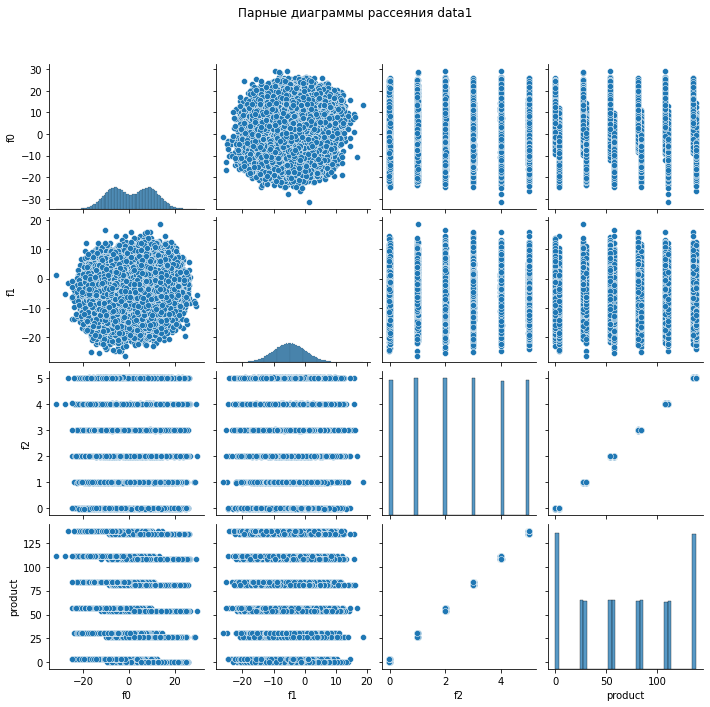

In [24]:
ax = sns.pairplot(data1)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Парные диаграммы рассеяния data1');

Между f2 и product четкая линейная зависимость

#### data2

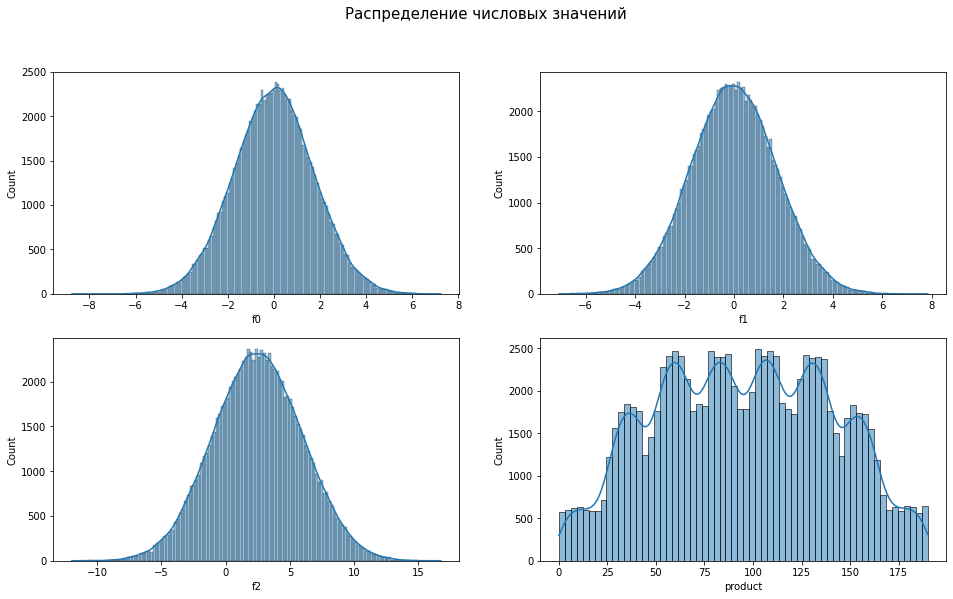

In [25]:
histplot(data2)

- f0, f1 и f2 распределены нормально
- product имеет несколько пиков

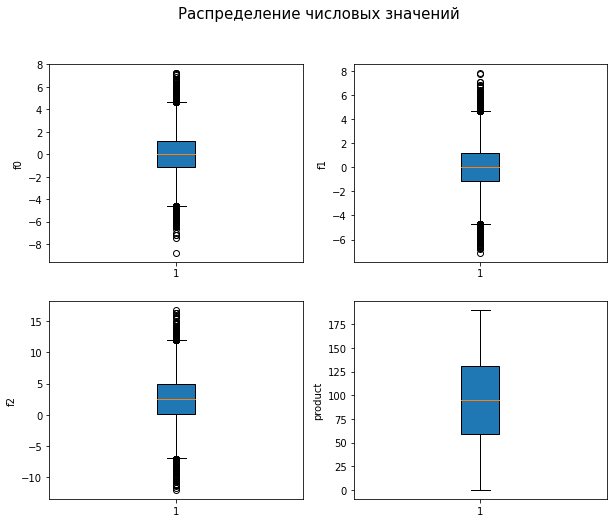

In [26]:
boxplot(data2)

f0, f1, f2 имеют высокие флуктуации

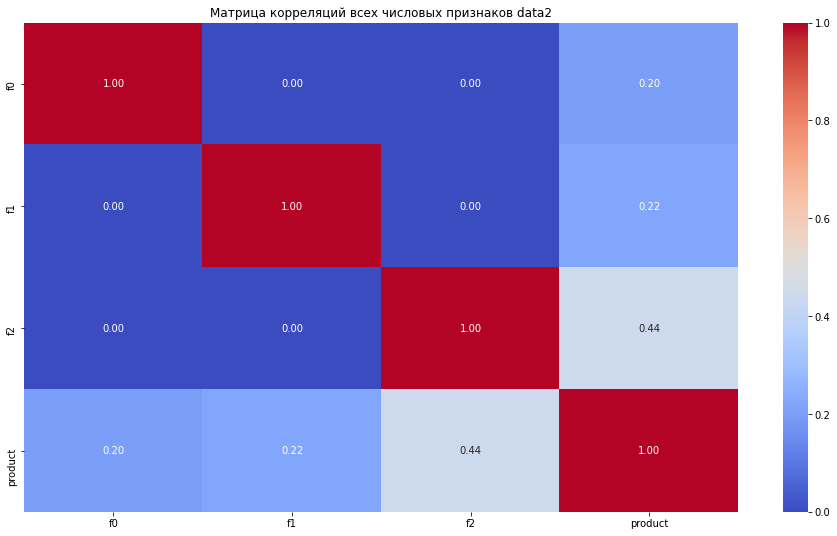

In [27]:
corr_matrix = data2.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Матрица корреляций всех числовых признаков data2')
plt.show();

В этом датасете нет высоких корреляция между числовыми признаками

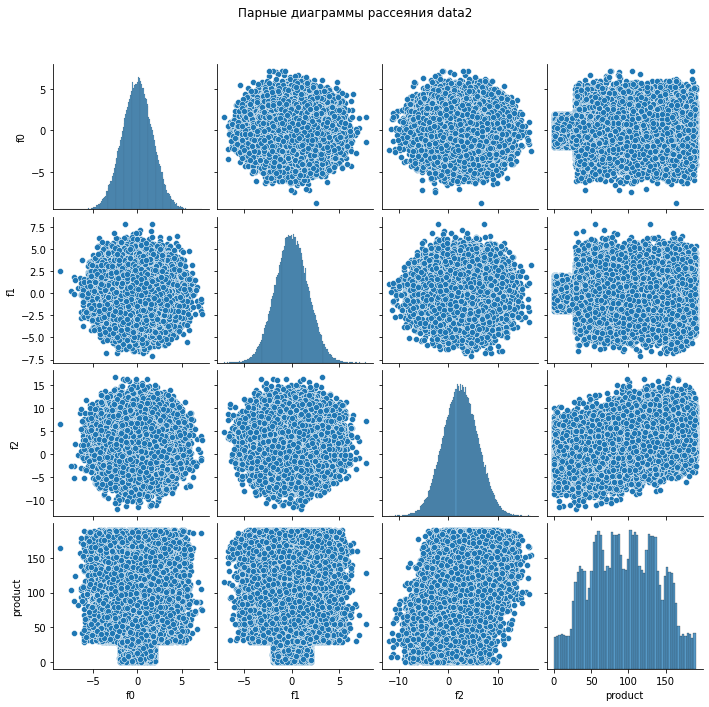

In [28]:
ax = sns.pairplot(data2)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Парные диаграммы рассеяния data2');

По диаграммме рассеяния тоже ничего не видно

Промежуточный вывод:

- Были загружены и отработаны исходные данные
- Был проведен исследовательский анализ данных, рассчитаны коэф. корреляций и рассмотрены диаграммы рассеяния, распределения и яшик с усами всех признаков
- Были отработаны шумы в данных с помощью квантилей

Для первого датасета стоит удалить стобец f2, поскольку у него мультиколлиниарность с показателем product, но из-за отсутствия информации о исходных данных оставим его.

## Обучение и проверка модели

- Входные признаки f0, f1, f2
- Целевой признак product
- Метрика качества RMSE

### Обучение

In [29]:
def linear_model(data):
    X = data.drop(['product'], axis=1)
    y = data['product']

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)
    
    linear = LinearRegression()
    scaler = MinMaxScaler()


    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    return linear, y_test, y_pred, mean_squared_error(y_test, y_pred)**0.5

In [30]:
linear0, y_test0, y_pred0, rmse0 = linear_model(data0)


linear1, y_test1, y_pred1, rmse1 = linear_model(data1)

linear2, y_test2, y_pred2, rmse2 = linear_model(data2)

In [31]:
print(f'data0, Средний запас сырья: {y_pred0.mean()}, RMSE={rmse0}')
print(f'data1, Средний запас сырья: {y_pred1.mean()}, RMSE={rmse1}')
print(f'data2, Средний запас сырья: {y_pred2.mean()}, RMSE={rmse2}')

data0, Средний запас сырья: 92.60984027552014, RMSE=37.68508926201444
data1, Средний запас сырья: 68.89405976528516, RMSE=0.888986499205162
data2, Средний запас сырья: 95.15574510105708, RMSE=39.84503874906559


RMSE у Региона 1, крайне низкий из-за того, что у нас высокая корреляция f2 с целевым признаком

In [32]:
final = pd.DataFrame()
final.index.name = 'region'
final['predicted_product_mean'] = [y_pred0.mean(), y_pred1.mean(), y_pred2.mean()]
final['RMSE'] = [rmse0, rmse1, rmse2]

### Промежуточные итоги

Были обучены три модели линейно регресии для определения объема нефти в скважине

0. Самый высокий запас сырья и самая низкая ошибка
1. Самый низкий запас и самая высокая ошибка, скорее всего потому, что мы удалили один из признаков из-за мультиколлиниарности
2. Практически такой же запас и такая же ошибка, как и в 0 регионе

## Подготовка к расчёту прибыли

**Условие задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [33]:
BUDGET_RUB = 10**10
QUANTITY_POINTS = 500
SELECTED_POINTS = 200
BARREL_PRICE_RUB = 450
UNIT_PRICE_RUB = 450 * 10**3
THRESHOLD = 2.5 / 100 

**Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.**

In [34]:
MIN_BARREL = round(BUDGET_RUB / SELECTED_POINTS / BARREL_PRICE_RUB / 10**3, 2)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {MIN_BARREL} тыс. баррель')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррель


In [35]:
print(f'Средний запас в регионе 0: {data0["product"].mean()}')
print(f'Средний запас в регионе 1: {data1["product"].mean()}')
print(f'Средний запас в регионе 2: {data2["product"].mean()}')

Средний запас в регионе 0: 92.49968421774354
Средний запас в регионе 1: 68.82391591804064
Средний запас в регионе 2: 94.99834211933378


По средним значениям в каждом регионе, можно сказать, что менее рисковано разрабатывать новую скважину в 0 и 2 регионе.

Рассмотрим каждый регион и посчитаем количество скважин у которых больше 111 тыс. баррель

In [36]:
print(f'Регион 0, % скважин с объемом сырья выше {MIN_BARREL}: {sum(data0["product"] >= MIN_BARREL) / data0.shape[0] * 100}')
print(f'Регион 1, % скважин с объемом сырья выше {MIN_BARREL}: {sum(data1["product"] >= MIN_BARREL) / data1.shape[0] * 100}')
print(f'Регион 2, % скважин с объемом сырья выше {MIN_BARREL}: {sum(data2["product"] >= MIN_BARREL) / data2.shape[0] * 100}')

Регион 0, % скважин с объемом сырья выше 111.11: 36.583658365836584
Регион 1, % скважин с объемом сырья выше 111.11: 16.536661466458657
Регион 2, % скважин с объемом сырья выше 111.11: 38.176527061082446


**Промежуточный итог**

Наименне рискованный регион для разработки новой скважины по проценту скважин с объемом сырья выше порога это Регион 2.

## Расчёт прибыли и рисков 

**Посчитайте риски и прибыль для каждого региона:**
1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [37]:
def income(y_test, y_pred):
    sort_series = pd.Series(y_pred).sort_values(ascending=False)[:SELECTED_POINTS]
    sort_test = (y_test[sort_series.index])
    sum_test = sort_test.sum()
    return round((sum_test * UNIT_PRICE_RUB) - BUDGET_RUB , 2)

In [38]:
print(f'Рассчетная прибыль в Регионе 0: {income(y_test0, y_pred0)}')
print(f'Рассчетная прибыль в Регионе 1: {income(y_test1, y_pred1)}')
print(f'Рассчетная прибыль в Регионе 2: {income(y_test2, y_pred2)}')

Рассчетная прибыль в Регионе 0: 3468529787.42
Рассчетная прибыль в Регионе 1: 2415086696.68
Рассчетная прибыль в Регионе 2: 2708100728.34


Из расчета потенциальной прибыли Регион 0 выйгрывает.

In [39]:
final['potentail_income'] = [income(y_test0, y_pred0), income(y_test1, y_pred1), income(y_test2, y_pred2)]

In [40]:
def confidence_interval(y_test, y_pred):
    samples = []
    for i in range(1000):
        sample = pd.Series(y_pred).sample(n = QUANTITY_POINTS, replace=True, random_state=RANDOM_STATE)
        samples.append(income(y_test, sample))
    samples = pd.Series(samples)
    mean = samples.mean()
    risk_per_cent = samples.apply(lambda x: x < 0).sum() / len(samples) * 100
    
    lower = samples.quantile(THRESHOLD)
    upper = samples.quantile(1 - THRESHOLD)
    return mean, risk_per_cent, round(lower, 2), round(upper, 2)

In [41]:
mean0, risk_per_cent0, lower0, upper0 = confidence_interval(y_test0, y_pred0)
mean1, risk_per_cent1, lower1, upper1 = confidence_interval(y_test1, y_pred1)
mean2, risk_per_cent2, lower2, upper2 = confidence_interval(y_test2, y_pred2)

In [42]:
final['mean_samples'] = [mean0, mean1, mean2]
final['risk_%'] = [risk_per_cent0, risk_per_cent1, risk_per_cent2]
final['lower'] = [lower0, lower1, lower2]
final['upper'] = [upper0, upper1, upper2]

In [43]:
final

,predicted_product_mean,RMSE,potentail_income,mean_samples,risk_%,lower,upper
region,,,,,,,
0,92.609840,37.685089,3.468530e+09,4.001870e+08,6.2,-1.379673e+08,9.173121e+08
1,68.894060,0.888986,2.415087e+09,4.559751e+08,1.1,5.384730e+07,8.722198e+08
2,95.155745,39.845039,2.708101e+09,3.846428e+08,9.3,-1.534387e+08,9.155028e+08


## Итоговый вывод

- Были обучены модели линейной регрессии
- Для каждого региона рассчитаны показатели:
    - Предсказанный средний объем сырья по всему региону
    - RMSE
    - Потенциальная прибыль
    - Процент риска освоения 200 месторождений в каждом регионе
    - Доверительный интервал в 95%
    
**По проценту риска, потенциальной прибыли и доверительному интервалу Регион 0 лучший по этим показателям, потом идет Регион 2 (ср. предсказанный объем продукта выше чем у Региона 0), который может быть тоже прибыльным и убыточный Регион 1** (причиной этого могло послужить, то, что при обучении модели мы отбросили один из признаков из-за мультиколлиниарность с целевый, поскольку нам неизвестно какие показатели за, что отвечают, нет возможности с полной уверенностью утверждать, что он будет убыточным)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован